# Latent Space Variational Geologic  Inversion from Multi-Source Dynamic Data
### Misael M. Morales, 2023
***

In [1]:
# Load my project packages
from utils_2d import *
keras.backend.clear_session()

2024-03-14 18:45:53.332663: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-14 18:45:53.332723: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-14 18:45:53.373239: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-14 18:45:53.451355: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-14 18:45:54.386617: W tensorflow/compiler/tf2

In [2]:
# Check tensorflow GPU settings
check_tensorflow_gpu()

Tensorflow built with CUDA? True
Tensorflow version: 2.15.0
# GPU available: 1
CUDA: 12.2 | cuDNN: 8
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


***
# Load all data and Visualize

In [3]:
### Load individual datasets from simulations
timestamps, poro, perm, channels, pressure, saturation, well_opr, well_wpr, well_wcut = load_initial_data()

Perm: (1000, 128, 128) | Poro: (1000, 128, 128) | Channels: (1000, 128, 128) | Pressure: (1000, 45, 128, 128) | Saturation: (1000, 45, 128, 128)
OPR: (1000, 45, 3) | WPR: (1000, 45, 3) | WCUT: (1000, 45, 3) | Timestamps: (45,)


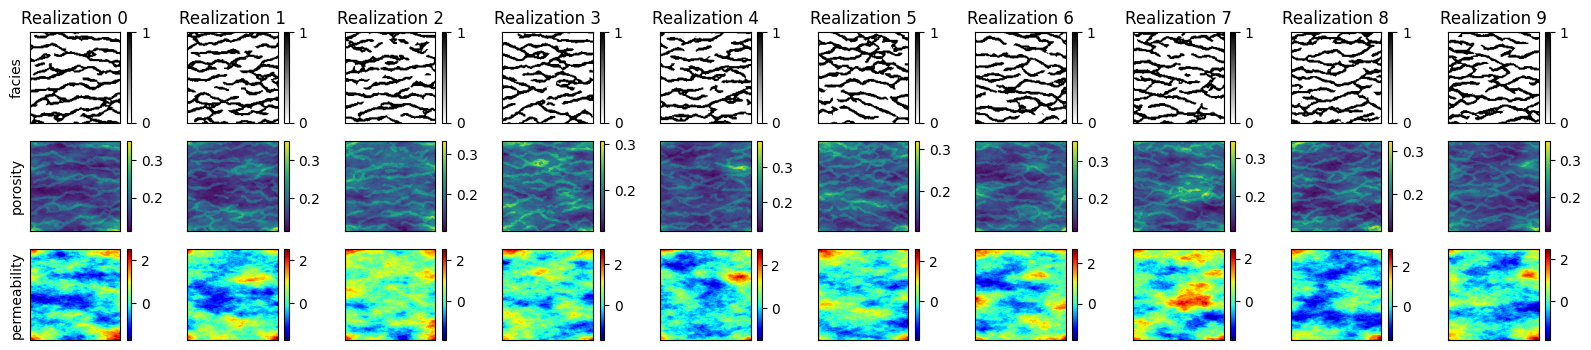

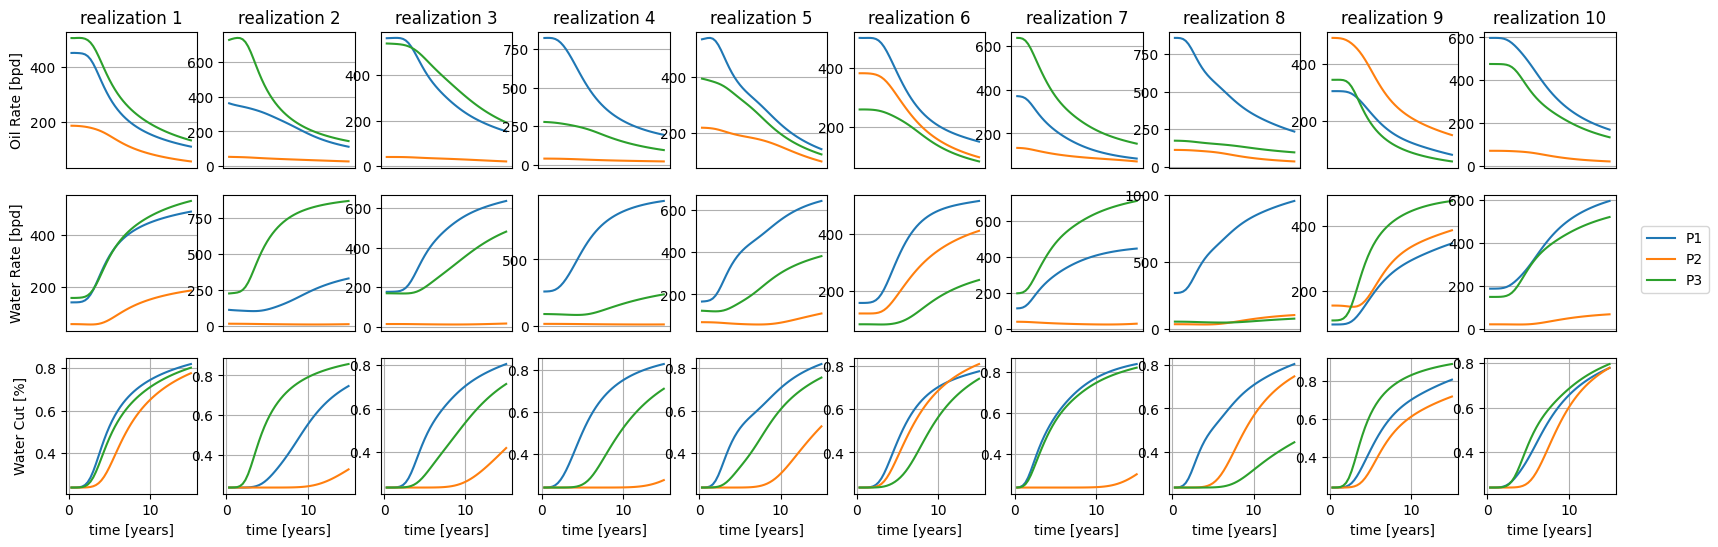

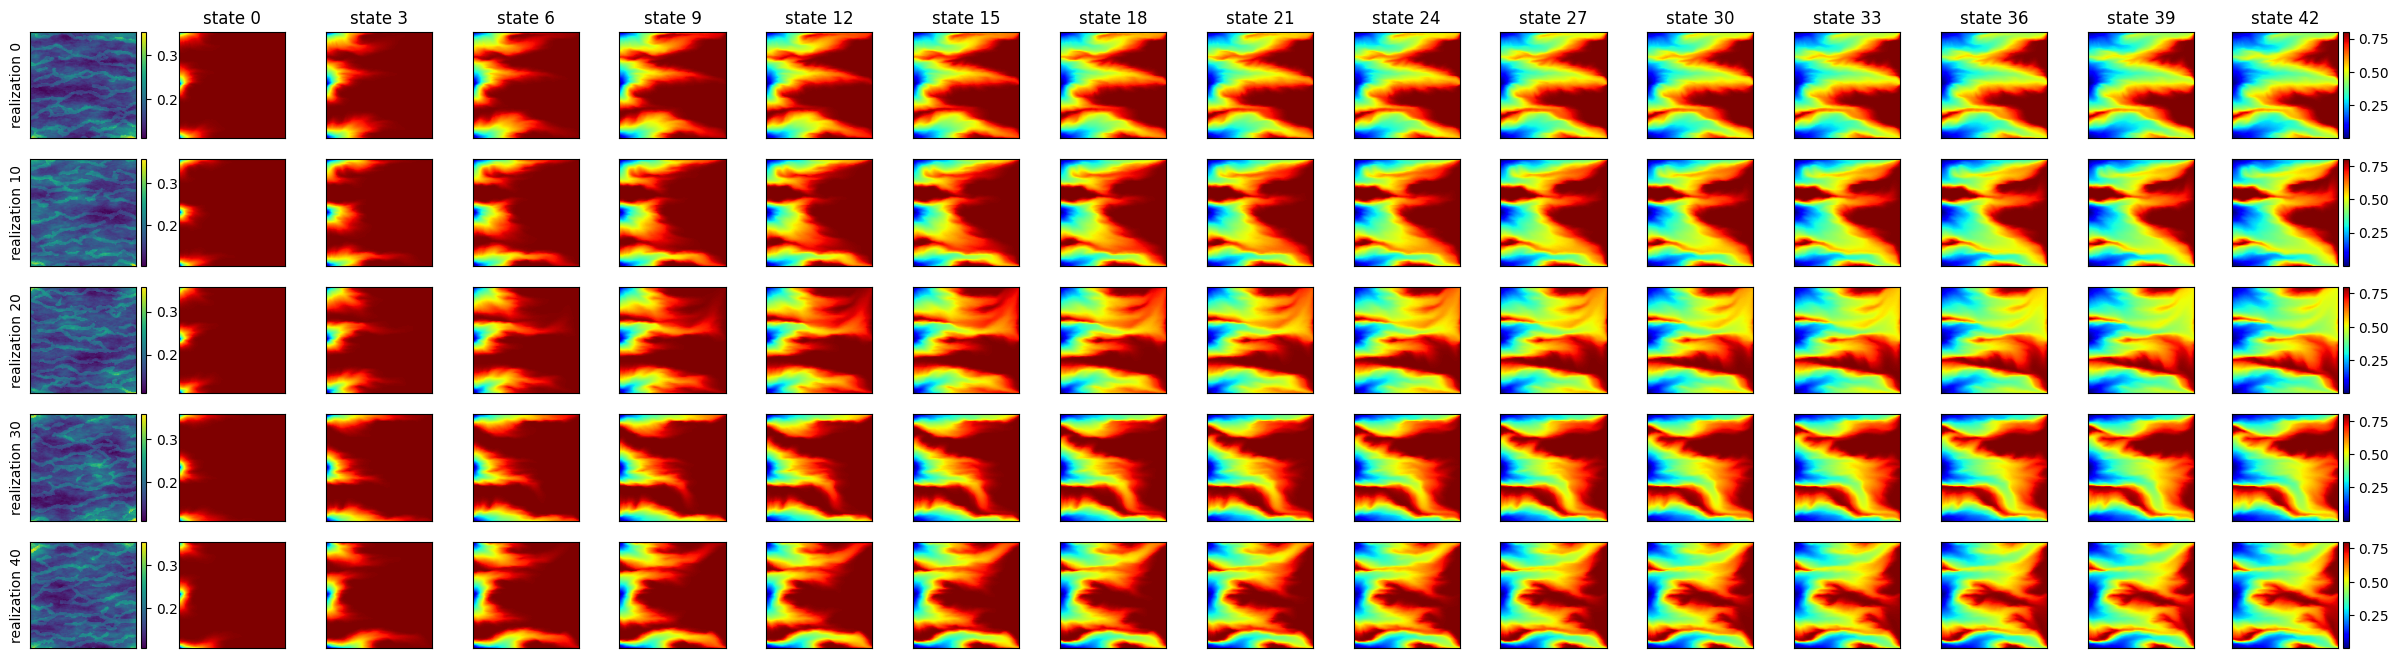

In [4]:
plot_static(poro, perm, channels)
plot_data(timestamps, well_opr, well_wpr, well_wcut)
plot_dynamic(poro, saturation, multiplier=10, cmaps=['viridis','jet'])

MovieWriter ffmpeg unavailable; using Pillow instead.


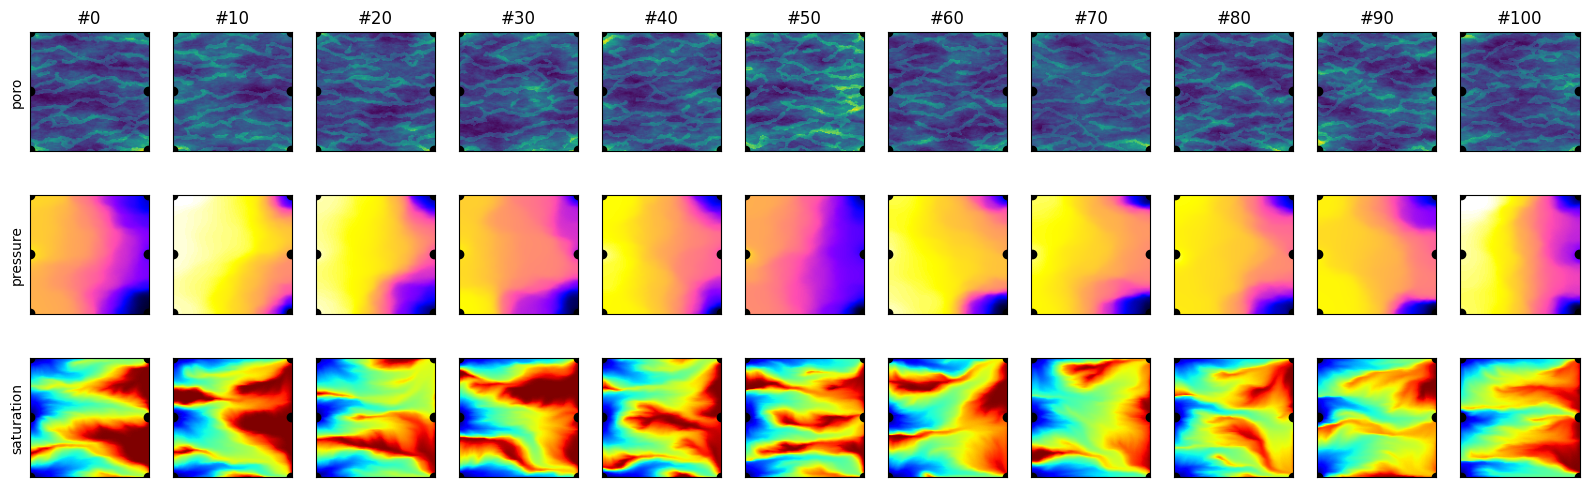

In [5]:
make_dynamic_animation(poro, [pressure,saturation])

***
# Data Processing
Load pre-existing data

Normalization, concatenate features and targets, train-test split

In [6]:
### (a) To split and normalize data into (x,y,w):
# X_data, y_data, w_data = split_xyw(poro, perm, channels, pressure, saturation, well_opr, well_wpr, well_wcut)

### (b) To load pre-computed, normalized (X,y,w,t):
X_data, y_data, w_data, timestamps = load_xywt()

X shape: (1000, 45, 128, 128, 2) | w shape: (1000, 45, 3, 3) 
y shape: (1000, 128, 128, 3) | t shape: (45,)


In [7]:
# Perform train-test split
X_train, X_test, y_train, y_test, w_train, w_test, randx, randy = my_train_test_split(X_data, y_data, w_data, nobs=30)

X_train shape: (700, 45, 30, 2)   | X_test shape: (300, 45, 30, 2)
w_train shape: (700, 45, 3, 3)    | w_test shape: (300, 45, 3, 3)
y_train shape: (700, 128, 128, 3) | y_test shape: (300, 128, 128, 3)


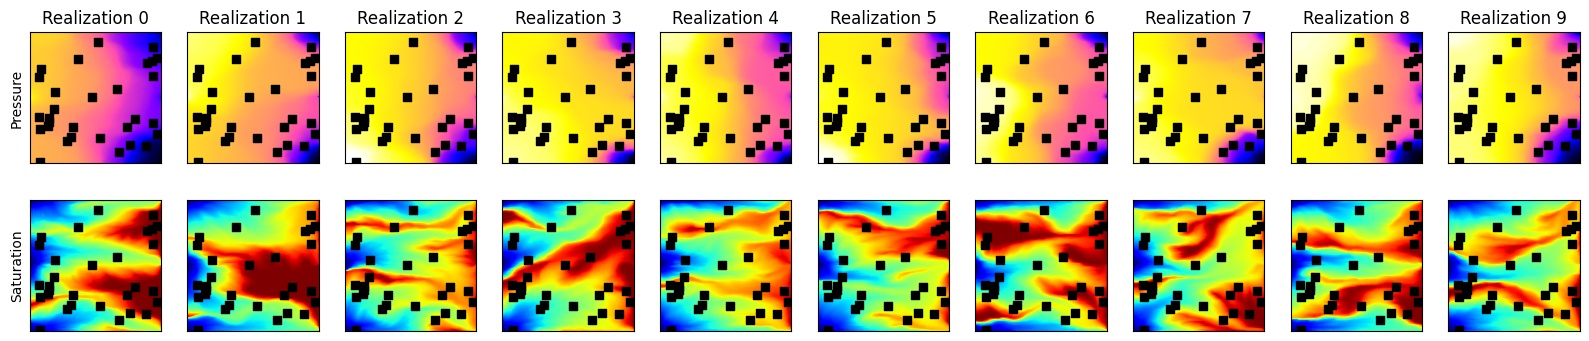

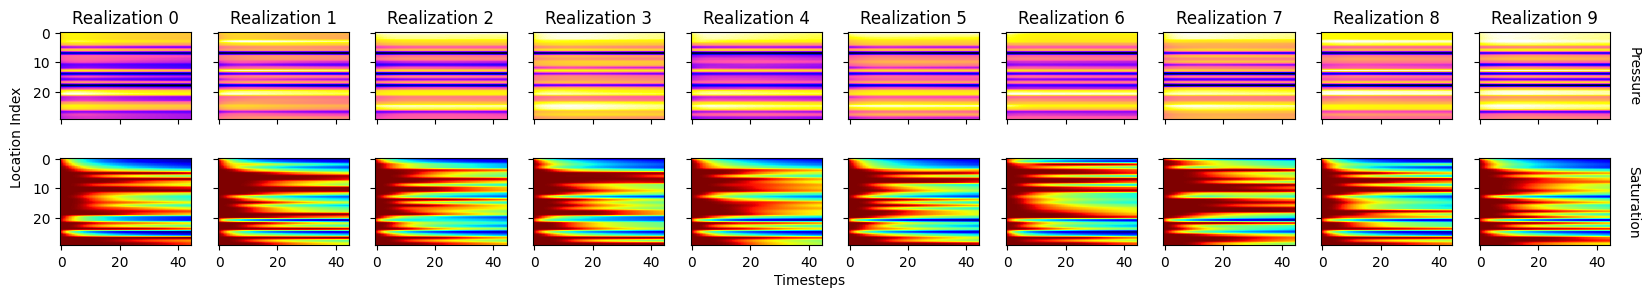

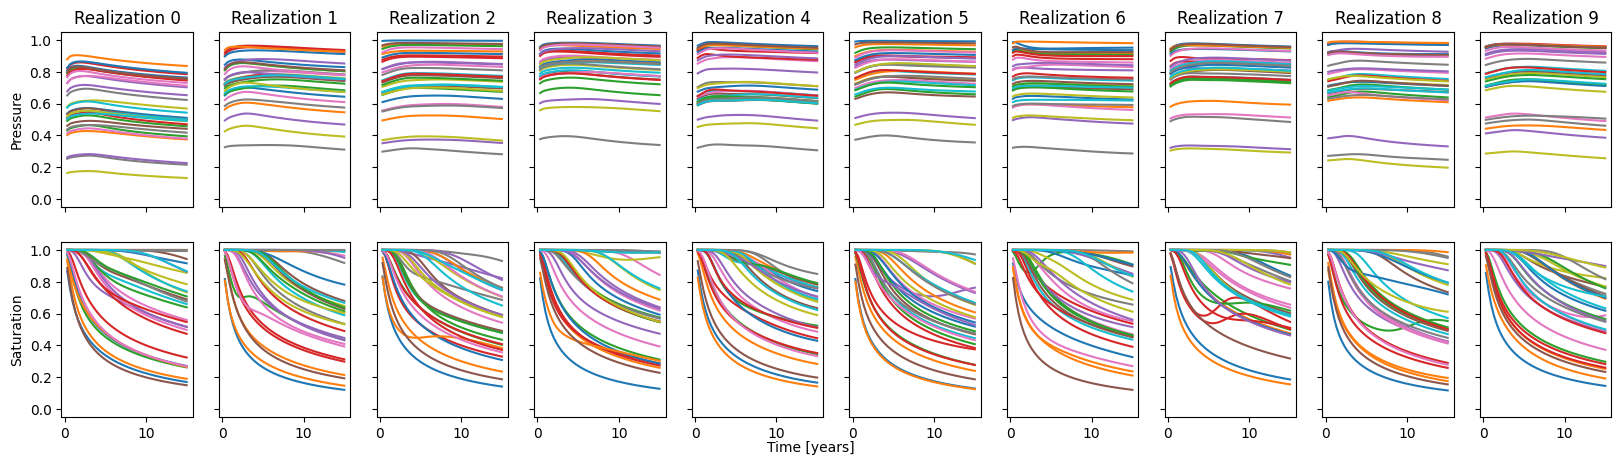

In [8]:
# Visualize X-samples
plot_X_img_observation(X_data, randx, randy)
plot_X_observation(X_train)
plot_X_line_observation(X_train, timestamps)

***
# Build, Compile, Train, and Predict with AutoEncoder Models
Run Train/Test Predictions

2024-03-14 18:50:02.819988: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied
2024-03-14 18:50:03.358969: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f2b699446a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-14 18:50:03.359002: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-03-14 18:50:03.369305: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-14 18:50:03.392835: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1710460203.465811    1202 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


# Parameters: 308,025 | Training time: 0.35 minutes


2024-03-14 18:50:29.271666: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied


# Parameters: 40,238 | Training time: 3.31 minutes
# Parameters: 5,610,120 | Training time: 0.39 minutes


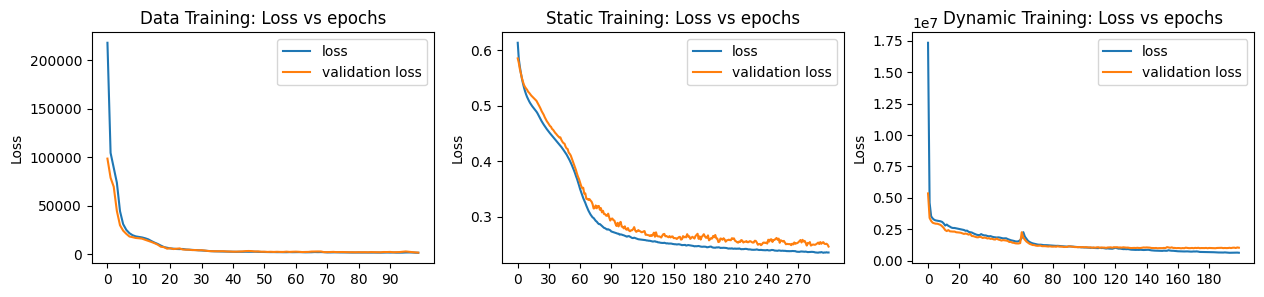

In [9]:
data_enc,    data_dec,    data_ae,    data_fit    = make_data_ae(w_train)
static_enc,  static_dec,  static_ae,  static_fit  = make_static_ae(y_train)
dynamic_enc, dynamic_dec, dynamic_ae, dynamic_fit = make_dynamic_ae(X_train)
plot_loss_all(data_fit, static_fit, dynamic_fit)

10/10 [==============================] - 0s 3ms/step
Train MSE: 4.98e-04 | Test MSE: 4.98e-04
Image data must have shape at least (7x7) for ssim calculation


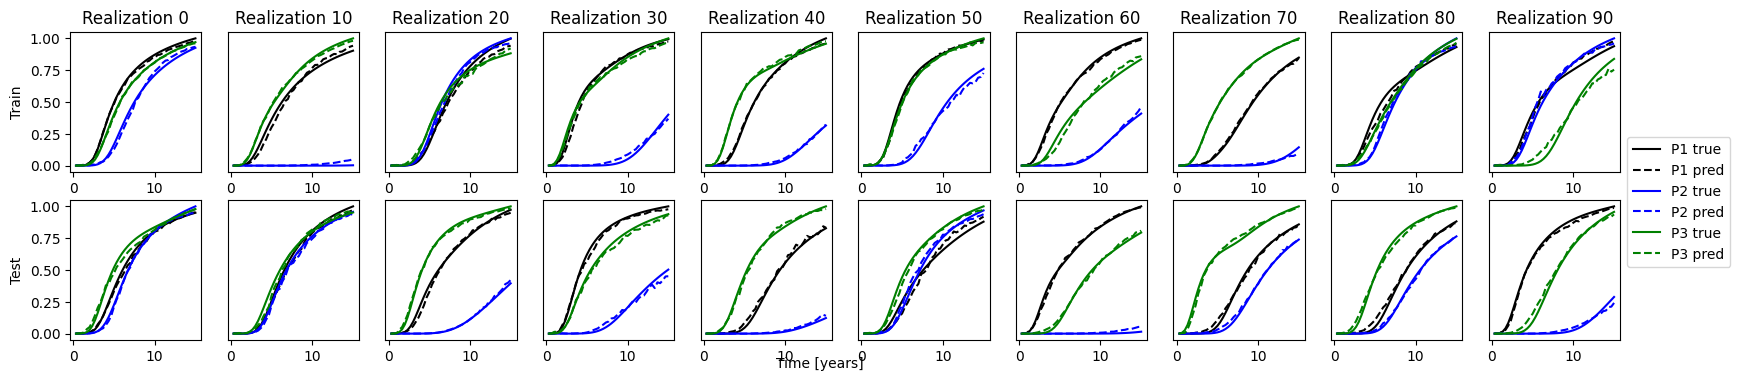

In [10]:
w_train_pred, w_test_pred = make_ae_prediction(w_train, w_test, data_ae)
plot_data_results(timestamps, w_train, w_test, w_train_pred, w_test_pred, channel_select=2, multiplier=10)

10/10 [==============================] - 0s 17ms/step
Train MSE: 2.75e-02 | Test MSE: 2.75e-02
Train SSIM: 83.24 | Test SSIM: 82.83


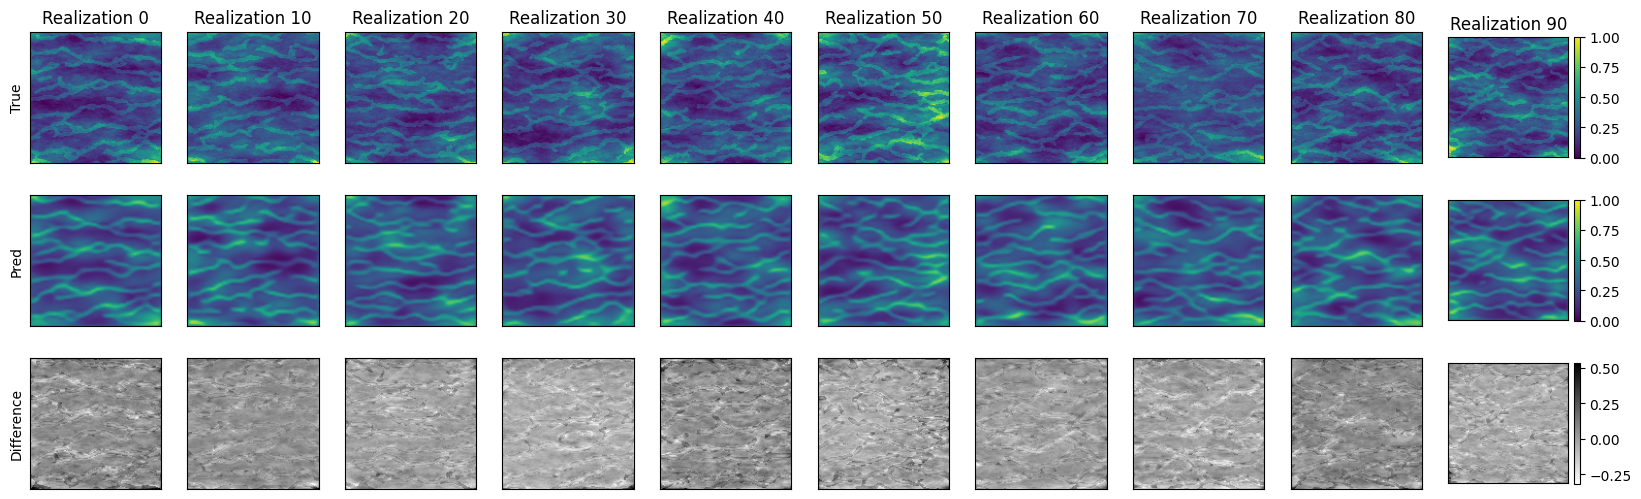

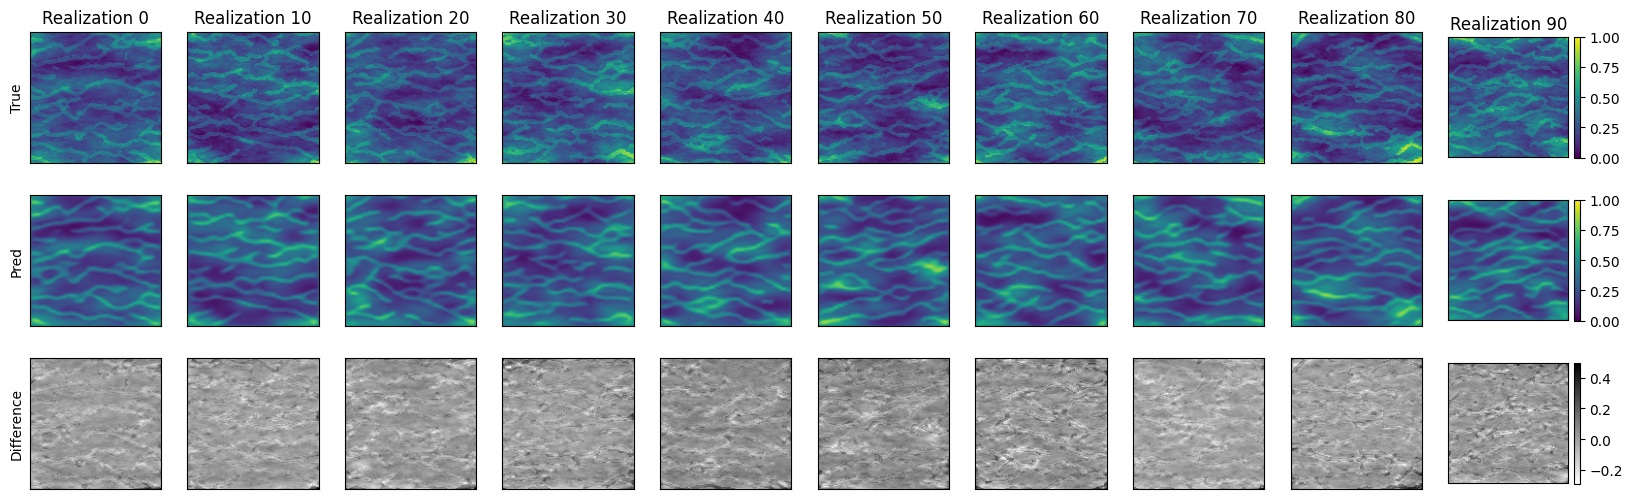

In [11]:
y_train_pred, y_test_pred = make_ae_prediction(y_train, y_test, static_ae)
plot_static_results(y_train, y_train_pred, multiplier=10, channel_select=0, cmaps=['viridis','gray_r'])
plot_static_results(y_test, y_test_pred, multiplier=10, channel_select=0, cmaps=['viridis','gray_r'])

10/10 [==============================] - 0s 5ms/step
Train MSE: 2.54e-03 | Test MSE: 2.54e-03
Train SSIM: 95.88 | Test SSIM: 93.85


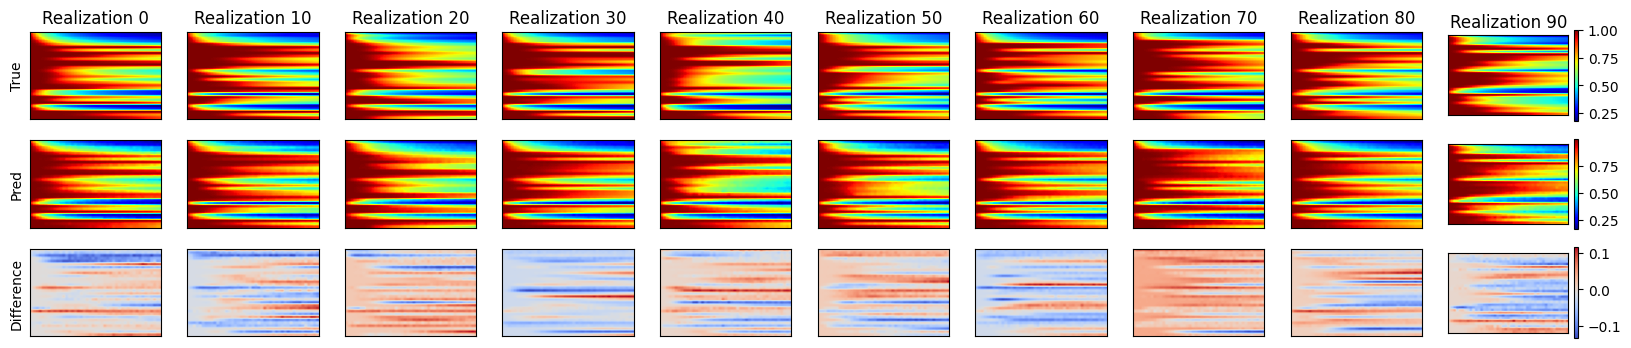

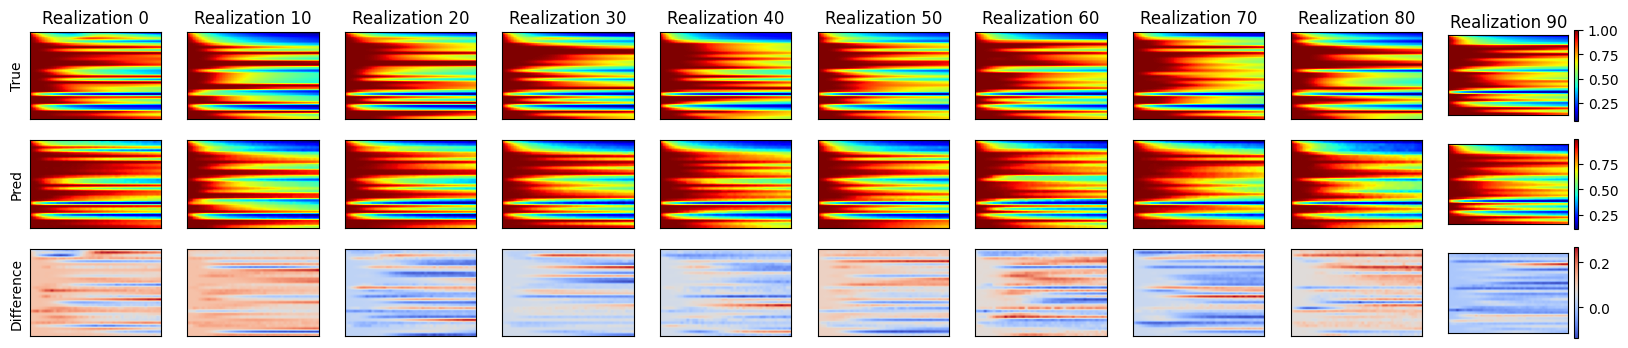

In [12]:
X_train_pred, X_test_pred = make_ae_prediction(X_train, X_test, dynamic_ae)
plot_dynamic_results(X_train, X_train_pred, multiplier=10, channel_select=1)
plot_dynamic_results(X_test, X_test_pred, multiplier=10, channel_select=1)

***
# Build, Compile, Train, and Predict with Latent-Inversion Network

In [13]:
X_full, w_full, y_full = make_full_traintest(X_train, X_test, w_train, w_test, y_train, y_test)

X_full: (1000, 45, 30, 2) | w_full: (1000, 45, 3, 3) | y_full: (1000, 128, 128, 3)


In [14]:
reg, reg_fit = make_inv_regressor(X_full, w_full, y_full, dynamic_enc, data_enc, static_dec)
plot_loss(reg_fit, figsize=(4,3))

In [ ]:
inv_train, inv_test = make_inv_prediction(reg, [X_train, X_test], [w_train, w_test], [y_train, y_test])

In [ ]:
plot_inversion_result(y_train, inv_train, multiplier=10, channel_select=0, cmaps=['viridis','gray_r'])

In [ ]:
plot_inversion_result(y_test, inv_test, multiplier=10, channel_select=0, cmaps=['viridis','gray_r'])

***
# Back-Normalize inversion results to original domain and visualize

In [ ]:
poro_hat, perm_hat, channels_hat = make_inv_backnorm([inv_train, inv_test], [poro, perm, channels])
plot_static(poro_hat, perm_hat, channels_hat, multiplier=10)

***
# END

In [ ]:
zm = static_enc.predict(y_train).reshape(700, 8, 8, 128)
zm.shape

In [ ]:
zm_mean = np.mean(zm, axis=-1)

plt.figure(figsize=(15,10))
k = 0
for i in range(10):
    for j in range(10):
        plt.subplot(10,10,k+1)
        plt.imshow(zm[k,...,0], cmap='jet')
        plt.xticks([]); plt.yticks([])
        k += 1
plt.tight_layout()
plt.show()